### data preprocess

In [10]:
import os, sys, csv
import numpy as np 
from random import shuffle
import argparse
from math import log, floor
import pandas as pd 
from sklearn import preprocessing


# preprocessing discrete
def _discrete(data):
    for i in range(len(data.columns)):
        if (isinstance(data[data.columns[i]][0], str)):
            feat = preprocessing.LabelEncoder().fit_transform(data[data.columns[i]])
            data[data.columns[i]] = feat
    return data

# IO file
def load_data(train_data_path, train_label_path, test_data_path):
# def load_data():
    X_train = pd.read_csv(train_data_path, sep = ',', header = 0)
    Y_train = pd.read_csv(train_label_path, sep = ',', header = 0)
    X_test = pd.read_csv(test_data_path, sep = ',', header = 0)

    X_train.drop('income', axis = 1, inplace = True)
    train = pd.concat([X_train, X_test], ignore_index = True)
    train = _discrete(train)

    X_train = train[:len(X_train)]
    X_test = train[len(X_train):]

    Y_train = np.array(Y_train.values)
    Y_train = Y_train[:, -1]

    X_train = np.array(X_train.values)

    for i in range(len(Y_train)):
        if ('>' in Y_train[i]):
            Y_train[i] = int(1)
        else:
            Y_train[i] = int(0)
    X_test = np.array(X_test.values)
    return (X_train, Y_train, X_test) 

(X_train, Y_train, X_test) = load_data('data/train.csv','data/train.csv', 'data/test.csv')
 
# print(X_train) # (32561, 14)
np.savetxt('data/X_train.txt',X_train,fmt='%d',delimiter=',')
# print(Y_train) 
np.savetxt('data/Y_train.txt',Y_train,fmt='%d',delimiter=',')
# print(X_test.shape) #(16281, 14)
np.savetxt('data/X_test.txt',X_test,fmt='%d',delimiter=',')

### Probabilistic Generative Model




$ z= \frac{P(x|C_1)P(C_1)}{P(x|C_1)P(C_1)+P(x|C_2)P(C_2)}
    =(\mu_1-\mu_2)^T\Sigma^{-1}x-\frac{1}{2}(\mu_1)^T\Sigma^{-1}\mu_1+\frac{1}{2}(\mu_2)^T\Sigma^{-1}\mu_2+\ln \frac{N_1}{N_2}
    =W^Tx+b$

In [25]:
from numpy.linalg import inv
class data_manager():
    def __init__(self):
        self.data = {}  
    
    def read(self,name,path):
        with open(path,newline = '') as csvfile:
            rows = np.array(list(csv.reader(csvfile))[:] ,dtype = float)  
            if name == 'X_train':
                self.mean = np.mean(rows,axis = 0).reshape(1,-1)
                self.std = np.std(rows,axis = 0).reshape(1,-1)
                self.theta = np.ones((rows.shape[1] + 1,1),dtype = float) 
                for i in range(rows.shape[0]):
                    rows[i,:] = (rows[i,:] - self.mean) / self.std  

            elif name == 'X_test': 
                for i in range(rows.shape[0]):
                    rows[i,:] = (rows[i,:] - self.mean) / self.std 

            self.data[name] = rows  

    def find_theta(self):
        class_0_id = []
        class_1_id = []
        for i in range(self.data['Y_train'].shape[0]):
            if self.data['Y_train'][i][0] == 0:
                class_0_id.append(i)
            else:
                class_1_id.append(i)

        class_0 = self.data['X_train'][class_0_id]
        class_1 = self.data['X_train'][class_1_id] 
        mean_0 = np.mean(class_0,axis = 0)
        mean_1 = np.mean(class_1,axis = 0)  

        n = class_0.shape[1]
        cov_0 = np.zeros((n,n))
        cov_1 = np.zeros((n,n))
        
        for i in range(class_0.shape[0]):
            cov_0 += np.dot(np.transpose([class_0[i] - mean_0]), [(class_0[i] - mean_0)]) / class_0.shape[0]

        for i in range(class_1.shape[0]):
            cov_1 += np.dot(np.transpose([class_1[i] - mean_1]), [(class_1[i] - mean_1)]) / class_1.shape[0]

        cov = (cov_0*class_0.shape[0] + cov_1*class_1.shape[0]) / (class_0.shape[0] + class_1.shape[0])
 
        self.w = np.transpose(((mean_0 - mean_1)).dot(inv(cov)) )
        self.b =  (- 0.5)* (mean_0).dot(inv(cov)).dot(mean_0)\
            + 0.5 * (mean_1).dot(inv(cov)).dot(mean_1)\
            + np.log(float(class_0.shape[0]) / class_1.shape[0]) 

        result = self.func(self.data['X_train'])
        answer = self.predict(result)


    def func(self,x):
        arr = np.empty([x.shape[0],1],dtype=float)
        for i in range(x.shape[0]):
            z = x[i,:].dot(self.w) + self.b
            z *= (-1)
            arr[i][0] = 1 / (1 + np.exp(z))
        return np.clip(arr, 1e-8, 1-(1e-8))

    def predict(self,x):
        ans = np.ones([x.shape[0],1],dtype=int)
        for i in range(x.shape[0]):
            if x[i] > 0.5:
                ans[i] = 0; 
                
        return ans

    def write_file(self,path):
        result = self.func(self.data['X_test'])
        answer = self.predict(result)
        with open(path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile) 
            writer.writerow(['id','label']) 
            for i in range(answer.shape[0]):
                writer.writerow([i+1,answer[i][0]])
                
                
dm = data_manager()
dm.read('X_train','data/X_train.txt')
dm.read('Y_train','data/Y_train.txt')
dm.read('X_test','data/X_test.txt')
dm.find_theta()
dm.write_file('output.csv')

## Logistic Regression

In [12]:
X_train_fpath = 'data/X_train.txt'
Y_train_fpath = 'data/Y_train.txt'
X_test_fpath = 'data/X_test.txt'
output_fpath = 'output_lr.csv'

X_train = np.genfromtxt(X_train_fpath, delimiter=',', skip_header=0)
Y_train = np.genfromtxt(Y_train_fpath, delimiter=',', skip_header=0)

In [30]:
def _normalize_column_0_1(X, train=True, specified_column = None, X_min = None, X_max=None):
    # The output of the function will make the specified column of the training data 
    # from 0 to 1
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the max value of the 
    # training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_max = np.reshape(np.max(X[:, specified_column], 0), (1, length))
        X_min = np.reshape(np.min(X[:, specified_column], 0), (1, length))
        
    X[:, specified_column] = np.divide(np.subtract(X[:, specified_column], X_min), np.subtract(X_max, X_min))

    return X, X_max, X_min

def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    # The output of the function will make the specified column number to 
    # become a Normal distribution
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the mean value and 
    # the variance of the training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
        X_std  = np.reshape(np.std(X[:, specified_column], 0), (1, length))
    
    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
     
    return X, X_mean, X_std


def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])
    
def train_dev_split(X, y, dev_size=0.25):
    train_len = int(round(len(X)*(1-dev_size)))
    return X[0:train_len], y[0:train_len], X[train_len:None], y[train_len:None]

# # These are the columns that I want to normalize
# col = [0,1,2,3,4,5,6,7,8,9,10,11,12]
# X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)



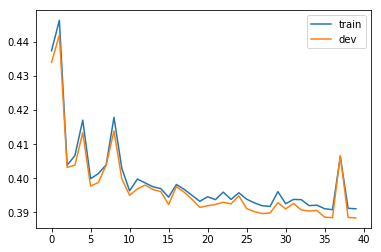

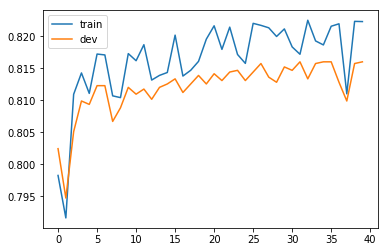

In [37]:

# These are the columns that I want to normalize
col = [0,2,3,4]
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)


def _sigmoid(z):
    # sigmoid function can be used to output probability
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)

def get_prob(X, w, b):
    # the probability to output 1
    return _sigmoid(np.add(np.matmul(X, w), b))

def infer(X, w, b):
    # use round to infer the result
    return np.round(get_prob(X, w, b))

def _cross_entropy(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)+lamda*w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _loss(y_pred, Y_label, lamda, w):
    return _cross_entropy(y_pred, Y_label) + lamda * np.sum(np.square(w))

def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc

def train(X_train, Y_train):
    # split a validation set
    dev_size = 0.1155
    X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)
    
    # Use 0 + 0*x1 + 0*x2 + ... for weight initialization
    w = np.zeros((X_train.shape[1],)) 
    b = np.zeros((1,))

    regularize = True
    if regularize:
        lamda = 0.001
    else:
        lamda = 0
    
    max_iter = 40  # max iteration number
    batch_size = 32 # number to feed in the model for average to avoid bias
    learning_rate = 0.2  # how much the model learn for each step
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    step =1

    loss_train = []
    loss_validation = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(max_iter):
        # Random shuffle for each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)
        
        total_loss = 0.0
        # Logistic regression train with batch
        for idx in range(int(np.floor(len(Y_train)/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]
            
            # Find out the gradient of the loss
            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)
            
            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad
            
            step = step+1
            
        # Compute the loss and the accuracy of the training set and the validation set
        y_train_pred = get_prob(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)
        
        y_dev_pred = get_prob(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(accuracy(Y_dev_pred, Y_dev))
        loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)
    
    return w, b, loss_train, loss_validation, train_acc, dev_acc  # return loss for plotting

import matplotlib.pyplot as plt
%matplotlib inline
# return loss is to plot the result
w, b, loss_train, loss_validation, train_acc, dev_acc= train(X_train, Y_train)

plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()

plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()


In [38]:
X_test = np.genfromtxt(X_test_fpath, delimiter=',', skip_header=1)
# Do the same data process to the test data
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

result = infer(X_test, w, b)

with open(output_fpath, 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(result):
            f.write('%d,%d\n' %(i+1, v))
            
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().rstrip('\n')
features = np.array([x for x in content.split(',')])
for i in ind[0:10]:
    print(features[i], w[i])
    

0 1.3441348061609364
7 0.8112954320030688
25 0.4552034531001
1 0.38756194763272644
40 0.3554084026357001
4 -0.3300431123076706
0 0.2480557355914849
3 -0.19413416310983295
2 0.1409332806172397
1 0.045948806820285515
